In [70]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import random
from skimage import morphology, transform
import matplotlib.pyplot as plt
from keras.models import load_model
from keras import backend as K
import tensorflow as tf
from skimage.io import imread, imread_collection
from skimage.segmentation import relabel_sequential
from skimage.morphology import label

In [38]:
seed=42
random.seed = seed
np.random.seed(seed)
BATCH_SIZE = 5

In [39]:
data = np.load('data.npz')
X_train = data['X_train']
y_train = data['y_train']
    
# data_gen_args = dict(rotation_range=90.,
#                          width_shift_range=0.1,
#                          height_shift_range=0.1,
#                          zoom_range=0.2,
#                          horizontal_flip=True,
#                          vertical_flip=True,
#                          fill_mode='wrap')
data_gen_args = dict()
image_datagen_train = ImageDataGenerator(**data_gen_args)
mask_datagen_train = ImageDataGenerator(**data_gen_args)
image_datagen_train.fit(y_train, augment=True, seed=seed)
mask_datagen_train.fit(y_train, augment=True, seed=seed)
image_generator_train = image_datagen_train.flow(
    X_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=seed)
mask_generator_train = mask_datagen_train.flow(
    y_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=seed)

In [40]:
def combine_generator(gen1, gen2):
    while True:
        yield(gen1.next(), gen2.next())
train_generator = combine_generator(image_generator_train, mask_generator_train)

In [41]:
def add_contour_to_image(image, mask):
#     image = np.squeeze(image, axis=0)
#     mask = np.squeeze(mask, axis=0)
#     mask = np.squeeze(mask, axis=2)
    # print(image.shape)
    kernel = np.matrix([[0,0,1,0,0],
                            [0,1,1,1,0],
                            [1,1,1,1,1],
                            [0,1,1,1,0],
                            [0,0,1,0,0] ], dtype=np.bool)

#     contour = np.logical_xor(mask, morphology.binary_erosion(mask, kernel))
    contour = np.logical_xor(mask, morphology.binary_erosion(mask))

    image[contour>0,0] = 255
    image[contour>0,1] = 50
    image[contour>0,2] = 0
    return image

(256, 256, 3)
(256, 256, 1)
(256, 256, 3)
(256, 256, 1)
(256, 256, 3)
(256, 256, 1)
(256, 256, 3)
(256, 256, 1)
(256, 256, 3)
(256, 256, 1)


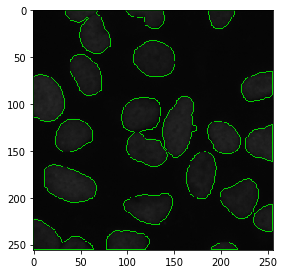

In [42]:
fig = plt.figure(figsize=(20,15))
images, masks = next(train_generator)
for image, mask in zip(images, masks) :
    
    print(image.shape)
    print(mask.shape)
    mask = np.squeeze(mask, axis=2)
    image = add_contour_to_image(image, mask)
    plt.subplot(331 + i)
    plt.imshow(image)
plt.show()

In [43]:
def mean_iou(y_true, y_pred):
    y_pred = tf.to_int32(y_pred > 0.5)
    score, up_opt = tf.metrics.mean_iou(y_true, y_pred, 2)
    K.get_session().run(tf.local_variables_initializer())
    with tf.control_dependencies([up_opt]):
        score = tf.identity(score)
    return score

6/6 [==============================] - 6s 926ms/step
(256, 256)
(519, 253)
(256, 256)
(256, 256)
(256, 256)
(512, 680)


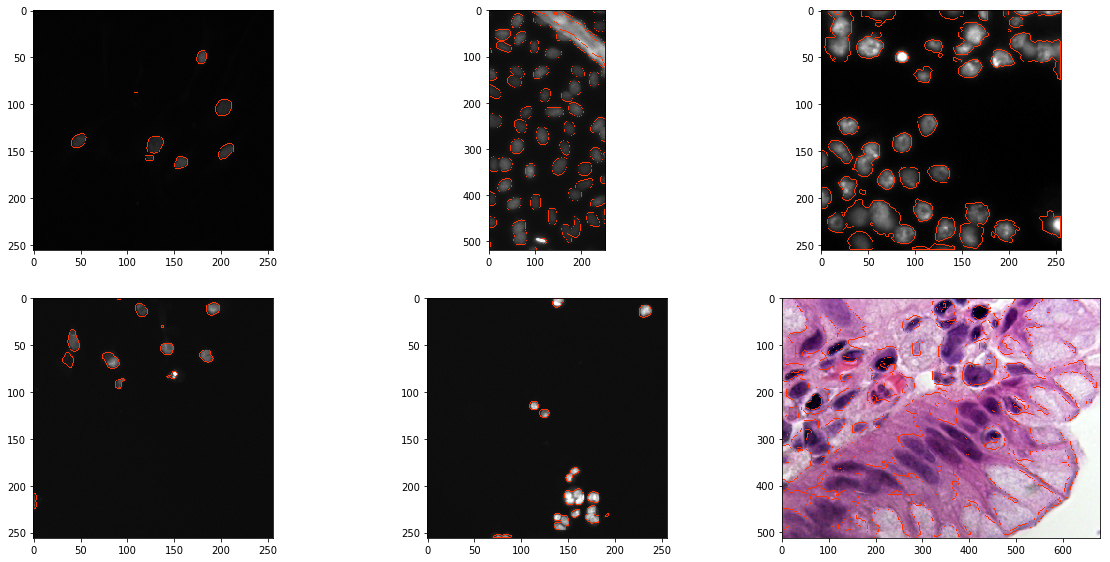

In [44]:
X_test = data['X_test'][:6]
X_orig = data['X_orig'][:6]

sizes_test = data['sizes_test'][:6]

model = load_model('model.h5', custom_objects={'mean_iou': mean_iou})

preds_test = model.predict(X_test, verbose=1)
preds_test_t = (preds_test > 0.5).astype(np.uint8)
preds_test_upsampled = []
for i in range(len(preds_test_t)):
    preds_test_upsampled.append(transform.resize(np.squeeze(preds_test_t[i]), (sizes_test[i][0], sizes_test[i][1]),
                                       mode='constant', preserve_range=True))

fig = plt.figure(figsize=(20,15))

for i in range(len(X_test)):
    print(preds_test_upsampled[i].shape)
    image = add_contour_to_image(X_orig[i], preds_test_upsampled[i])
    plt.subplot(331 + i)
    plt.imshow(image)
plt.show()

1/1 [==============================] - 1s 554ms/step


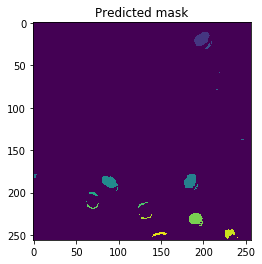

Number of true objects: 13
Number of predicted objects: 26
Thresh	TP	FP	FN	Prec.
0.500	5	20	7	0.156
0.550	5	20	7	0.156
0.600	4	21	8	0.121
0.650	4	21	8	0.121
0.700	4	21	8	0.121
0.750	3	22	9	0.088
0.800	3	22	9	0.088
0.850	2	23	10	0.057
0.900	0	25	12	0.000
0.950	0	25	12	0.000
AP	-	-	-	0.091


In [82]:
plt.close('all')
id = 'f67e72b7fe0b1e3648ea745ffd395c80705c89b0c0c48227991fe6f5815b2a18'
file = "../input/stage1_train/{}/images/{}.png".format(id,id)
masks = "../input/stage1_train/{}/masks/*.png".format(id)
image = imread(file)
masks = imread_collection(masks).concatenate()
height, width, _ = image.shape
num_masks = masks.shape[0]

# Make a ground truth label image (pixel value is index of object label)
labels = np.zeros((height, width), np.uint16)
for index in range(0, num_masks):
    labels[masks[index] > 0] = index + 1

# # Show label image
# fig = plt.figure()
# plt.imshow(image)
# plt.title("Original image")
# fig = plt.figure()
# plt.imshow(labels)
# plt.title("Ground truth masks")

# # Simulate an imperfect submission
# offset = 2 # offset pixels
# y_pred = labels[offset:, offset:]
# y_pred = np.pad(y_pred, ((0, offset), (0, offset)), mode="constant")
# y_pred[y_pred == 20] = 0 # Remove one object
img = image[:,:,:3]
img = img[np.newaxis,:,:]
y_pred = model.predict(img, verbose=1)
y_pred = np.squeeze(y_pred, axis=0)
y_pred = np.squeeze(y_pred, axis=2)
cutoff = 0.5
y_pred = label(y_pred > cutoff)
# plt.imshow(lab_img)
# plt.show()

y_pred, _, inverse_map = skimage.segmentation.relabel_sequential(y_pred) # Relabel objects

# Show simulated predictions
fig = plt.figure()
plt.imshow(y_pred)

plt.title("Predicted mask")
plt.show()

# Compute number of objects
true_objects = len(np.unique(labels))
pred_objects = len(np.unique(y_pred))
print("Number of true objects:", true_objects)
print("Number of predicted objects:", pred_objects)

# Compute intersection between all objects
intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

# Compute areas (needed for finding the union between all objects)
area_true = np.histogram(labels, bins = true_objects)[0]
area_pred = np.histogram(y_pred, bins = pred_objects)[0]
area_true = np.expand_dims(area_true, -1)
area_pred = np.expand_dims(area_pred, 0)

# Compute union
union = area_true + area_pred - intersection

# Exclude background from the analysis
intersection = intersection[1:,1:]
union = union[1:,1:]
union[union == 0] = 1e-9

# Compute the intersection over union
iou = intersection / union

# Precision helper function
def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1   # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
    return tp, fp, fn

# Loop over IoU thresholds
prec = []
print("Thresh\tTP\tFP\tFN\tPrec.")
for t in np.arange(0.5, 1.0, 0.05):
    tp, fp, fn = precision_at(t, iou)
    p = tp / (tp + fp + fn)
    print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
    prec.append(p)
print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))